In [2]:
import torch
import time
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import random
import math
import matplotlib.pyplot as plt
import scipy.signal
from scipy.interpolate import make_interp_spline, BSpline
import scipy.interpolate as interpolate
import os
import random
from os import listdir
from os.path import isfile, join
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import scipy.signal
from collections import Counter
from pdb import set_trace as st
from matplotlib.colors import hsv_to_rgb
import torch.nn.functional as F


In [3]:
# def sort_samples_from_source(per_class_count, num_class):
#     # Gets *per_class_count* instances of num_class 
#     output = {}
    
#     for classes in range(num_class):
        
#         output[classes] = []
#         current_count = 0
            
            
#         for f in listdir('./data_polar'):
#             label = f.split('_')[0].split('c')[1]
            
#             if int(label)-1 == classes:
                
#                 data = np.load(join('./data_polar', f))
#                 output[classes].append(data)
#                 current_count += 1
#                 if current_count == per_class_count:
#                     break
                             
#     for classes in range(num_class):
#         output[classes] = np.array(output[classes])
        
#         xshape = output[classes].shape
#         data_x = output[classes].reshape((xshape[0], xshape[1], 1, xshape[2], xshape[3]))
#         data_x[:, 0,...] = np.arccos(data_x[:, 0, 0,...]).reshape(data_x[:, 0,...].shape)
#         data_x[:, 1,...] = data_x[:, 4,...]
#         data_x = data_x[:, :2,...]
#         output[classes] = data_x

#     return output

In [4]:
# some_samples = sort_samples_from_source(5, 11)

In [8]:
class Iterative_wFM(nn.Module):
    
    def __init__(self, in_channels, kernel_size, initialize_test=False):
        super(Iterative_wFM, self).__init__()
        
        if initialize_test:
            self.mag_kernel = torch.nn.Parameter(torch.ones((in_channels, kernel_size)), requires_grad=True)
#             self.phase_kernel = torch.nn.Parameter(torch.rand((channel)), requires_grad=True)
            self.phase_kernel = torch.tensor(3.14)
            self.bias = torch.tensor(50)
        
        else:
            self.mag_kernel = torch.nn.Parameter(torch.rand((in_channels, kernel_size)), requires_grad=True)
            self.phase_kernel = torch.nn.Parameter(torch.rand((in_channels)), requires_grad=True)
            self.bias = torch.nn.Parameter(torch.rand((in_channels)), requires_grad=True)
#             self.phase_kernel1 = torch.nn.Parameter(torch.rand((channel)), requires_grad=True) #maybe try this
        self.in_channels = in_channels
        self.kern_size = kernel_size
        
    def apply_kernel(self, inputs):
        # Input of shape [Batch, 2, channel, kernel_size, #blocks]
        
        # Applies the kernel to the inputs, expect same shape as the weights 
        mag_kernel_weights = self.mag_kernel / torch.cumsum(self.mag_kernel, dim=1) #compute successive weights, should be same dimension as kernel
        phase_kernel = self.phase_kernel
        bias = self.bias
        # The wFM is calculated along the **kernel_size** dimension where 
        # the first entry would be m1 in documentation

        # I noticed that the wFM is always in the form of mag/phase so there is no need to represent it in cartesian form
        first_mean = inputs[:, :, :, 0, :] # [Batch, 2, #channel, #blocks]
        x_mag = torch.sqrt(torch.sum(first_mean**2, dim=1)) # [Batch, #channel, #blocks]
        x_phase = torch.atan2(first_mean[:, 1, ...], first_mean[:, 0, ...])
        
        x_mag = torch.transpose(x_mag, 1, 2)
        x_phase = torch.transpose(x_phase, 1, 2)
#         st()
#         print("First mag is: "+str(x_mag))
#         print("First phase is: "+str(x_phase))
        for i in range(1, self.kern_size):
            current_input = inputs[:, :, :, i, :] # [Batch, 2, # channel, #blocks]
            y_mag = torch.sqrt(torch.sum(current_input**2, dim=1)) # [Batch, #channel, #blocks]
            y_phase = torch.atan2(current_input[:, 1, ...], current_input[:, 0, ...]) # [Batch, #channel, #blocks]
            
            y_mag = torch.transpose(y_mag, 1, 2) # [Batch, #blocks, #channels]
            y_phase = torch.transpose(y_phase, 1, 2) # [Batch, #blocks, #channels]

            t = mag_kernel_weights[:, i] # [#channel]
            phase = torch.acos(x_phase * y_phase) # [#channel]


            new_mag = x_mag * (((y_mag + bias)/(x_mag + bias)) ** t) #- bias # - bias
            new_phase = 1 / torch.sin(phase) * (torch.sin(t * phase) * x_phase + torch.sin((1 - t) * phase) * y_phase)


            x_mag = new_mag
            x_phase = new_phase
            
#         st()

        print(torch.max(x_mag))
        print(torch.min(x_mag))


        print(torch.max(x_phase))
        print(torch.min(x_phase))
        final_x = x_mag * torch.cos(x_phase).unsqueeze(1) # [Batch, 1, #blocks, #channels]
        final_y = x_mag * torch.sin(x_phase).unsqueeze(1) # [Batch, 1, #blocks, #channels]
        
        final_x = torch.transpose(final_x, 2, 3)
        final_y = torch.transpose(final_y, 2, 3)
        
        # Output of shape [Batch, 2, #channels, #blocks]
        return torch.cat((final_x, final_y), dim=1)


In [9]:
G = Iterative_wFM(1, 2)

tensor(1.3546, grad_fn=<MaxBackward1>)
tensor(0.2269, grad_fn=<MinBackward1>)
tensor(3.0874, grad_fn=<MaxBackward1>)
tensor(-3.0874, grad_fn=<MinBackward1>)
torch.Size([1, 2, 1, 900])
1.3546457
0.22689705
3.0874326
-3.0874326


<IPython.core.display.Javascript object>


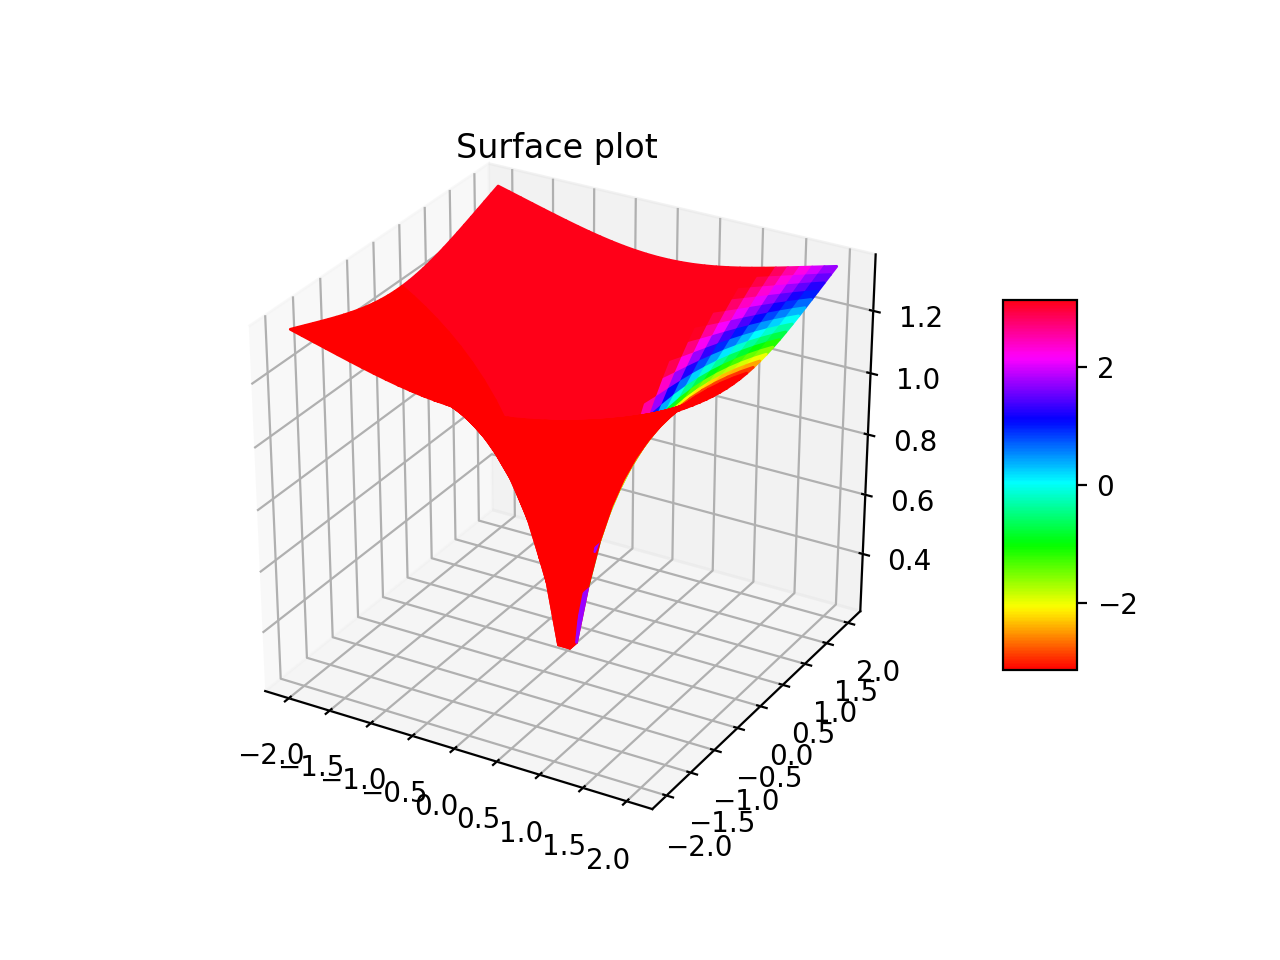

In [11]:
%matplotlib notebook

from matplotlib import cm

# test_input = torch.tensor([[[1], [0.5]], [[1], [0.3]]])
# G.apply_kernel(test_input)
from mpl_toolkits import mplot3d

# This is plotting with (x, y) in [-2, 2] x [-2, 2]
start = -2 # Plotting starts with
end = 2 # Plotting ends with
num_samples_between = 30 # Number of slices between start and end

x_values = np.outer(np.linspace(start, end, num_samples_between), np.ones(num_samples_between))
y_values = x_values.copy().T

# Input should be [B, 2, channel, kernel_size, #blocks] ---> [B, 2, 1, 2, 30*30]

x = torch.tensor(x_values).reshape(-1).unsqueeze(0).float()
y = torch.tensor(y_values).reshape(-1).unsqueeze(0).float()


# Add 1 along kernel dimension on x axis because doing wFM(z, 1) with 1 = 1 + 0*i
x = torch.cat((x, torch.ones((1, num_samples_between*num_samples_between))), dim=0)

# Add 0 along kernel dimension on y axis because doing wFM(z, 1) with 1 = 1 + 0*i
y = torch.cat((y, torch.zeros((1, num_samples_between*num_samples_between))), dim=0)

# x, y of shape [2, 30, 30]

x = x.unsqueeze(0).unsqueeze(0).unsqueeze(0)
y = y.unsqueeze(0).unsqueeze(0).unsqueeze(0)

z = torch.cat((x, y), dim=1)

results = G.apply_kernel(z)
print(results.shape)

results = results.reshape(1, 2, 1, num_samples_between, num_samples_between).detach().numpy()

x = results[0, 0, 0, :, :]
y = results[0, 1, 0, :, :]

mag = np.sqrt(x**2 + y**2)
phase = np.arctan2(y,x)

print(np.max(mag))
print(np.min(mag))


print(np.max(phase))
print(np.min(phase))
normalized_phase = (phase - np.min(phase)) / (np.max(phase) - np.min(phase))

fig = plt.figure()
ax = plt.axes(projection='3d')


facecolors = cm.hsv(phase)

surf = ax.plot_surface(x_values, y_values, mag, facecolors=facecolors, cmap='hsv', edgecolor='none')
ax.set_title('Surface plot')
fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax)
surf.set_clim(vmin=-3.14, vmax=3.14)
plt.show()

tensor(2.0879, grad_fn=<MaxBackward1>)
tensor(0.4299, grad_fn=<MinBackward1>)
tensor(0.3493, grad_fn=<MaxBackward1>)
tensor(-0.3493, grad_fn=<MinBackward1>)
2.087946
0.42985123
0.34925172
-0.34925172


<IPython.core.display.Javascript object>


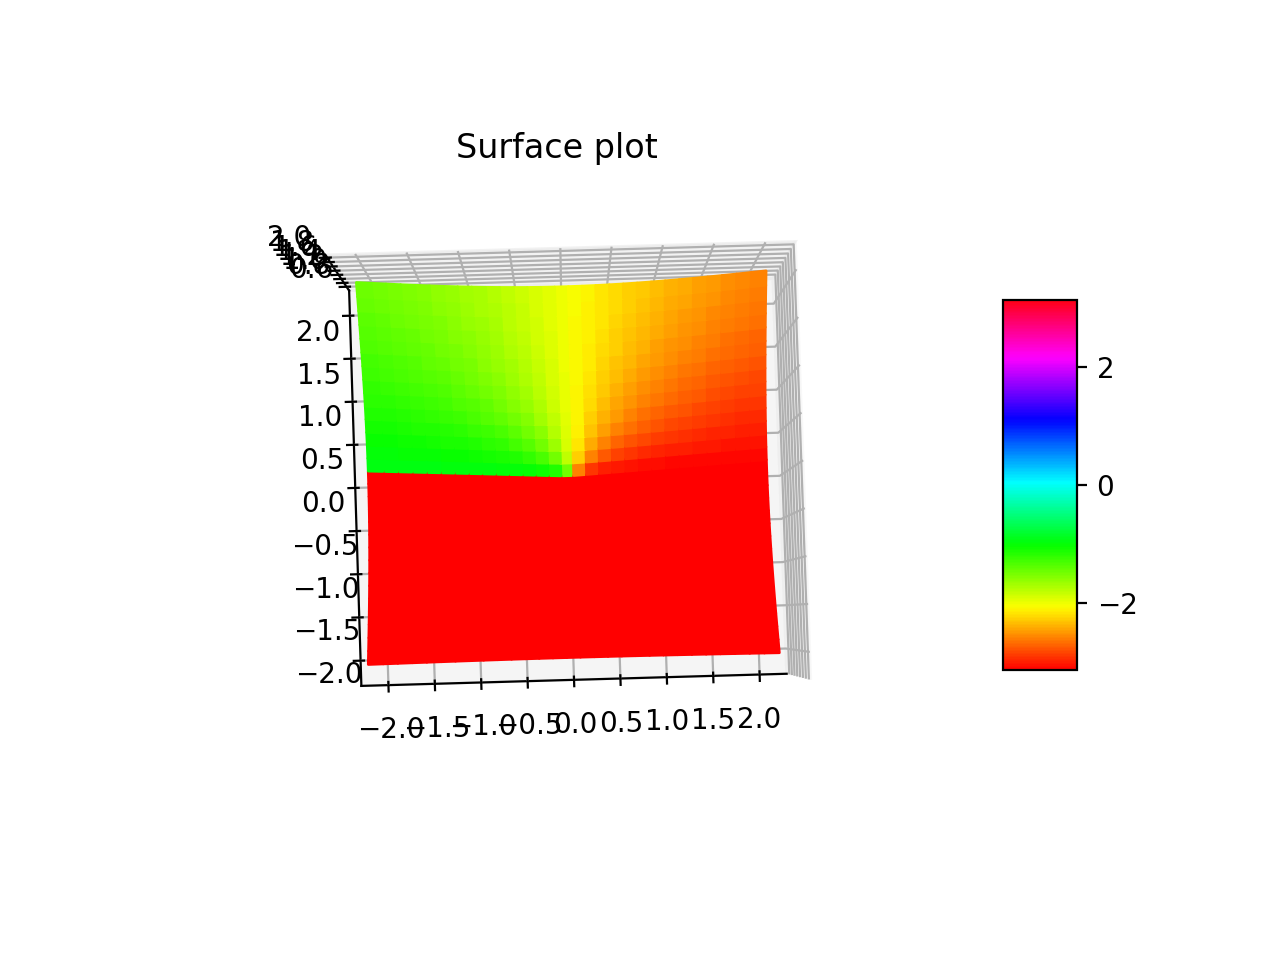

In [12]:
%matplotlib notebook

from matplotlib import cm

# test_input = torch.tensor([[[1], [0.5]], [[1], [0.3]]])
# G.apply_kernel(test_input)
from mpl_toolkits import mplot3d


start = -2 # Plotting starts with
end = 2 # Plotting ends with
num_samples_between = 30 # Number of slices between start and end

x_values = np.outer(np.linspace(start, end, num_samples_between), np.ones(num_samples_between))
y_values = x_values.copy().T

# Input should be [B, 2, channel, kernel_size, #blocks] ---> [B, 2, 1, 2, 30*30]

x = torch.tensor(x_values).reshape(-1).unsqueeze(0).float()
y = torch.tensor(y_values).reshape(-1).unsqueeze(0).float()


# Add 1 along kernel dimension on x axis because doing wFM(z, 1) with 1 = 1 + 0*i
x = torch.cat((torch.ones((1, num_samples_between*num_samples_between)), x))

# Add 0 along kernel dimension on y axis because doing wFM(z, 1) with 1 = 1 + 0*i
y = torch.cat((torch.zeros((1, num_samples_between*num_samples_between)), y))

# x, y of shape [2, 30, 30]

x = x.unsqueeze(0).unsqueeze(0).unsqueeze(0)
y = y.unsqueeze(0).unsqueeze(0).unsqueeze(0)

z = torch.cat((x, y), dim=1)

results = G.apply_kernel(z).reshape(1, 2, 1, num_samples_between, num_samples_between).detach().numpy()

x = results[0, 0, 0, :, :]
y = results[0, 1, 0, :, :]

mag = np.sqrt(x**2 + y**2)
phase = np.arctan2(y,x)

print(np.max(mag))
print(np.min(mag))
print(np.max(phase))
print(np.min(phase))
normalized_phase = (phase - np.min(phase)) / (np.max(phase) - np.min(phase))

fig = plt.figure()
ax = plt.axes(projection='3d')

facecolors = cm.hsv(phase)

surf = ax.plot_surface(x_values, y_values, mag, facecolors=facecolors, cmap='hsv', edgecolor='none')
ax.set_title('Surface plot')
fig.colorbar(surf, shrink=0.5, aspect=5)
surf.set_clim(vmin=-3.14, vmax=3.14)
plt.show()

In [13]:
def gen_data(magnum_angles):
    c = torch.zeros(1, 2, 1, num_angles, 1)
    for i in range(num_angles):
        c[:, 1, :, i, :] = 

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [ ]:
# print(x.reshape(-1).reshape((30, 30)))
False in (x.reshape(-1).reshape((30, 30)) == x).numpy()

In [ ]:
c = torch.rand((3, 2, 5))
d = torch.rand((5))
(c*d).shape

In [ ]:
kernel_size = 2
channel = 1

mag_kernel = torch.nn.Parameter(torch.ones((kernel_size, channel)), requires_grad=True)
mag_kernel_weights = mag_kernel / torch.cumsum(mag_kernel, dim=0) #compute successive weights, should be same dimension as kernel
print(mag_kernel_weights)
phase_kernel = torch.nn.Parameter(torch.rand((kernel_size, channel)), requires_grad=True)

phase_kernel1 = torch.nn.Parameter(torch.rand((channel)), requires_grad=True)
bias = torch.nn.Parameter(torch.rand((channel)), requires_grad=True)

inputs = torch.rand((2, kernel_size, channel)) # Inputs of size [2, kernel_size, channel]

print(inputs)
# The wFM is calculated along the **kernel_size** dimension where the first entry would be m1 in documentation

# I noticed that the wFM is always in the form of mag/phase so there is no need to represent it in cartesian form
first_mean = inputs[:, 0, ...] # [2, #channel]
previous_mag = torch.sqrt(torch.sum(first_mean**2, dim=0)) # [#channel]
previous_phase = torch.atan2(first_mean[1, ...], first_mean[0, ...])

for i in range(1, len(inputs)):
    current_input = inputs[:, i, ...] # [2, #channel]
    y_mag = torch.sqrt(torch.sum(current_input**2, dim=0)) # [#channel]
    y_phase = torch.atan2(current_input[1, ...], current_input[0, ...])
    
    
    
    t = mag_kernel_weights[i] # [#channel]
    phase = phase_kernel1 # [#channel]
    
    
    new_mag = previous_mag * (((y_mag + bias)/(previous_mag + bias)) ** t) - bias
    new_phase = 1 / torch.sin(phase) * (torch.sin(t * phase) * previous_phase + torch.sin((1 - t) * phase) * y_phase)
    
    
    previous_mag = new_mag
    previous_phase = new_phase
    
final_x = previous_mag * torch.cos(previous_phase)
final_y = previous_mag * torch.sin(previous_phase)

    

In [ ]:
final_x

In [ ]:
final_y

In [ ]:
kernel = torch.cumsum(kernel, dim=0)

In [ ]:
kernel